# PyTorch Transfer Learning

 1.   Freezing all the layers except the final one
 2.   Freezing the first few layers
 3.   Fine-tuning the entire network.

The following pre-trained models are available on PyTorch

 *   resnet18, resnet34, resnet50, resnet101, resnet152
 *   squeezenet1_0, squeezenet1_1
 *   Alexnet
 *   inception_v3
 *   Densenet121, Densenet169, Densenet201
 *   Vgg11, vgg13, vgg16, vgg19, vgg11_bn. vgg13_bn, vgg16_bn, vgg19_bn

In [1]:
import sys
sys.version

'3.6.7 (default, Oct 22 2018, 11:32:17) \n[GCC 8.2.0]'

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
#import torch

In [3]:
!pip install Pillow
!pip install image

In [0]:
%matplotlib inline

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [6]:
import torch
print(torch.__version__)

0.4.1


In [7]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [8]:
torch.cuda.is_available()

True

### Get Data

In [0]:
DATASET_ZIP_FILE = 'flower_data.zip'

In [0]:
from zipfile import ZipFile
files = os.listdir()
if not DATASET_ZIP_FILE in files:
  !curl --header 'Host: s3.amazonaws.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:63.0) Gecko/20100101 Firefox/63.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --header 'Upgrade-Insecure-Requests: 1' 'https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip' --output 'flower_data.zip'  
  '''
  !pip install kaggle
  from google.colab import files
  files.upload()
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  #this permissions change avoids a warnong on Kaggle tool startup
  !chmod 600 ~/.kaggle/kaggle.json  
  !kaggle datasets download -d moltean/fruits
  '''
  !ls
  with ZipFile(DATASET_ZIP_FILE, 'r') as zipF:
    zipF.extractall()
    print('UnZip Done')

In [0]:
data_dir = 'flower_data/'
PATH = data_dir

train_dir = 'train'
val_dir = 'valid'

In [0]:
batch_size = 16

In [13]:
# again, list total number of classes, and list them all
# os.list dir sorting depends on OS dependent file indexing, so leaving it as it is

classes = os.listdir(f'{data_dir}/{train_dir}')
classes.sort()
ClassesNumer = len(classes)
print("Class Total Count: ", ClassesNumer)
#print(classes)


Class Total Count:  102


In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    train_dir: transforms.Compose([
        #transforms.Resize(224),
        transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        #transforms.RandomRotation(degrees=90),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
       # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    val_dir: transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

In [0]:

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in [train_dir, val_dir]}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in [train_dir, val_dir]}

dataset_sizes = {x: len(image_datasets[x]) for x in [train_dir, val_dir]}

class_names = image_datasets[train_dir].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [16]:
print(dataloaders)
print(dataset_sizes)
print(device)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2c75d615c0>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x7f2c75d721d0>}
{'train': 6552, 'valid': 818}
cuda:0


In [17]:
print(image_datasets[train_dir])


Dataset ImageFolder
    Number of datapoints: 6552
    Root Location: flower_data/train
    Transforms (if any): Compose(
                             RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None


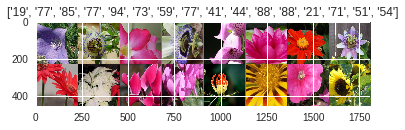

In [18]:
#Let’s visualize a few training images so as to understand the data augmentations.
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders[train_dir]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

###Training the model

Now, let’s write a general function to train a model. Here, we will illustrate:

    Scheduling the learning rate
    Saving the best model

In the following, parameter ''scheduler'' is an LR scheduler object from ''torch.optim.lr_scheduler''.

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in [train_dir, val_dir]:
            if phase == train_dir:
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == train_dir):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == train_dir:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == val_dir and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
# Load a pretrained model and reset final fully connected layer
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft.fc = nn.Linear(num_ftrs, ClassesNumer)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [21]:
# To view which layers are freeze and which layers are not freezed:
for name, child in model_ft.named_children():
  for name_2, params in child.named_parameters():
    print(name_2, params.requires_grad)

weight True
weight True
bias True
0.conv1.weight True
0.bn1.weight True
0.bn1.bias True
0.conv2.weight True
0.bn2.weight True
0.bn2.bias True
0.conv3.weight True
0.bn3.weight True
0.bn3.bias True
0.downsample.0.weight True
0.downsample.1.weight True
0.downsample.1.bias True
1.conv1.weight True
1.bn1.weight True
1.bn1.bias True
1.conv2.weight True
1.bn2.weight True
1.bn2.bias True
1.conv3.weight True
1.bn3.weight True
1.bn3.bias True
2.conv1.weight True
2.bn1.weight True
2.bn1.bias True
2.conv2.weight True
2.bn2.weight True
2.bn2.bias True
2.conv3.weight True
2.bn3.weight True
2.bn3.bias True
0.conv1.weight True
0.bn1.weight True
0.bn1.bias True
0.conv2.weight True
0.bn2.weight True
0.bn2.bias True
0.conv3.weight True
0.bn3.weight True
0.bn3.bias True
0.downsample.0.weight True
0.downsample.1.weight True
0.downsample.1.bias True
1.conv1.weight True
1.bn1.weight True
1.bn1.bias True
1.conv2.weight True
1.bn2.weight True
1.bn2.bias True
1.conv3.weight True
1.bn3.weight True
1.bn3.bias Tru

In [22]:
# Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 2.7232 Acc: 0.4388
valid Loss: 0.8270 Acc: 0.8435

Epoch 1/24
----------
train Loss: 0.8637 Acc: 0.8335
valid Loss: 0.2657 Acc: 0.9548

Epoch 2/24
----------
train Loss: 0.4829 Acc: 0.9017
valid Loss: 0.1605 Acc: 0.9597

Epoch 3/24
----------
train Loss: 0.3332 Acc: 0.9330
valid Loss: 0.1206 Acc: 0.9719

Epoch 4/24
----------
train Loss: 0.2608 Acc: 0.9473
valid Loss: 0.1050 Acc: 0.9707

Epoch 5/24
----------
train Loss: 0.2340 Acc: 0.9496
valid Loss: 0.0857 Acc: 0.9817

Epoch 6/24
----------
train Loss: 0.1995 Acc: 0.9574
valid Loss: 0.0778 Acc: 0.9853

Epoch 7/24
----------
train Loss: 0.1719 Acc: 0.9634
valid Loss: 0.0644 Acc: 0.9890

Epoch 8/24
----------
train Loss: 0.1455 Acc: 0.9707
valid Loss: 0.0640 Acc: 0.9878

Epoch 9/24
----------
train Loss: 0.1453 Acc: 0.9712
valid Loss: 0.0660 Acc: 0.9878

Epoch 10/24
----------
train Loss: 0.1437 Acc: 0.9713
valid Loss: 0.0624 Acc: 0.9902

Epoch 11/24
----------
train Loss: 0.1306 Acc: 0.9744
valid Loss

In [0]:
"""
# Generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[val_dir]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
"""        

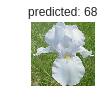

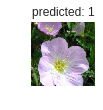

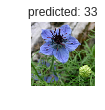

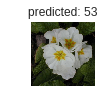

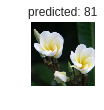

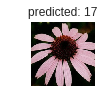

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f2cb24ad9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil

In [24]:
#visualize_model(model_ft)

ConvNet as fixed feature extractor: Training only the last fully connected layer
----------------------
Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [26]:
#Freeze all layers first
for param in model_ft.parameters():
    param.requires_grad = False
    
# Then unfreeze last classification layer only for feature extract
for param in model_ft.fc.parameters():
    param.requires_grad = True    

    
# To view which layers are freeze and which layers are not freezed:
for name, child in model_ft.named_children():
  for name_2, params in child.named_parameters():
    print(name_2, params.requires_grad)

weight False
weight False
bias False
0.conv1.weight False
0.bn1.weight False
0.bn1.bias False
0.conv2.weight False
0.bn2.weight False
0.bn2.bias False
0.conv3.weight False
0.bn3.weight False
0.bn3.bias False
0.downsample.0.weight False
0.downsample.1.weight False
0.downsample.1.bias False
1.conv1.weight False
1.bn1.weight False
1.bn1.bias False
1.conv2.weight False
1.bn2.weight False
1.bn2.bias False
1.conv3.weight False
1.bn3.weight False
1.bn3.bias False
2.conv1.weight False
2.bn1.weight False
2.bn1.bias False
2.conv2.weight False
2.bn2.weight False
2.bn2.bias False
2.conv3.weight False
2.bn3.weight False
2.bn3.bias False
0.conv1.weight False
0.bn1.weight False
0.bn1.bias False
0.conv2.weight False
0.bn2.weight False
0.bn2.bias False
0.conv3.weight False
0.bn3.weight False
0.bn3.bias False
0.downsample.0.weight False
0.downsample.1.weight False
0.downsample.1.bias False
1.conv1.weight False
1.bn1.weight False
1.bn1.bias False
1.conv2.weight False
1.bn2.weight False
1.bn2.bias False
1

In [28]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.00001, momentum=0.9)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1259 Acc: 0.9750
valid Loss: 0.0660 Acc: 0.9878

Epoch 1/24
----------
train Loss: 0.1297 Acc: 0.9727
valid Loss: 0.0651 Acc: 0.9902

Epoch 2/24
----------
train Loss: 0.1349 Acc: 0.9730
valid Loss: 0.0621 Acc: 0.9927

Epoch 3/24
----------
train Loss: 0.1244 Acc: 0.9768
valid Loss: 0.0602 Acc: 0.9914

Epoch 4/24
----------
train Loss: 0.1256 Acc: 0.9759
valid Loss: 0.0600 Acc: 0.9914

Epoch 5/24
----------
train Loss: 0.1315 Acc: 0.9728
valid Loss: 0.0611 Acc: 0.9914

Epoch 6/24
----------
train Loss: 0.1284 Acc: 0.9725
valid Loss: 0.0626 Acc: 0.9914

Epoch 7/24
----------
train Loss: 0.1175 Acc: 0.9762
valid Loss: 0.0605 Acc: 0.9890

Epoch 8/24
----------
train Loss: 0.1260 Acc: 0.9745
valid Loss: 0.0657 Acc: 0.9902

Epoch 9/24
----------
train Loss: 0.1368 Acc: 0.9693
valid Loss: 0.0615 Acc: 0.9902

Epoch 10/24
----------
train Loss: 0.1340 Acc: 0.9722
valid Loss: 0.0641 Acc: 0.9890

Epoch 11/24
----------
train Loss: 0.1251 Acc: 0.9745
valid Loss

In [0]:
#visualize_model(model_conv)

#plt.ioff()
#plt.show()